#  GP latent function inference

This notebook uses GP to infer a latent function $\lambda(x)$, which parameterises the exponential distribution:
$$(y_1, y_2) \sim SomeCopula(\lambda),$$
where:
$$\lambda = (2 \cdot \Phi(f) - 1) \in (-1,+1)$$
is a GP link function, which transforms the latent gaussian process variable:
$$f \sim GP \in (-\infty,+\infty).$$

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

import sys
home = '/home/nina/CopulaGP/'
sys.path.insert(0, home)

import bvcopula
import utils
from bvcopula import conf

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#here we specify a 'true' latent function lambda
theta1 = lambda x: -0.9+0*x#*np.sin(x*np.pi*2)
theta2 = lambda x: 3+0*x#*np.cos(x*3) + 5.5
con = lambda x: 0.5 + 0.4*np.cos(3*x) #np.clip(np.cos(2*np.pi*0.5*x)**5*0.5+0.5+0.8*(np.random.rand()-0.5),0,1) #*np.sin(2*np.pi*3*x+.6)
math.log(2)

0.6931471805599453

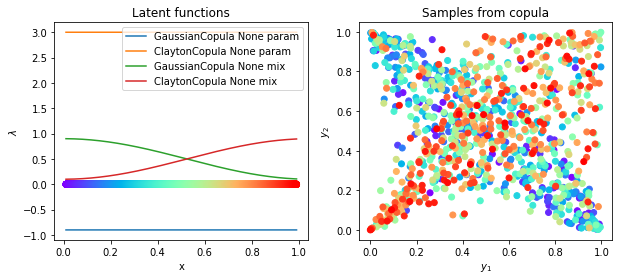

In [3]:

import matplotlib.cm as cm

#x_space setup
NSamp = int(10000)
X = np.linspace(0.01,.99,NSamp) 

# model setup
theta = torch.stack([torch.tensor([theta1(x) for x in X]),
                     torch.tensor([theta2(x) for x in X])]).float()
mix = torch.stack([torch.tensor([con(x) for x in X]),
                  torch.tensor([1-con(x) for x in X])]).float()
mix[1] = 1.-mix[0]
# theta = torch.tensor([theta1(x) for x in X]).unsqueeze(0).float()
# mix = torch.ones(len(X)).unsqueeze(0).float()
likelihoods = [bvcopula.GaussianCopula_Likelihood(),#(rotation='0°'),
               bvcopula.ClaytonCopula_Likelihood()#(rotation='180°')
              ]
copulas = [lik.copula for lik in likelihoods]
rotations = [lik.rotation for lik in likelihoods]
copula_model = bvcopula.MixtureCopula(theta,mix,copulas,rotations=rotations)

# #generate samples
Y = copula_model.sample().numpy().squeeze()
colors = cm.rainbow(np.linspace(0., 1., Y.shape[0]))

# #plot model parameters and samples
fig, (lambdaf, samples) = plt.subplots(1,2,figsize=(10,4))

fp = utils.LatentSpacePlot('Latent functions','x','$\lambda$',lambdaf)
fp.plot(X,copula_model, colors=colors)

sp = utils.PlotSamples('Samples from copula','$y_1$','$y_2$',samples)
sp.plot(copula_model, Y[::10], colors[::10])

fig.show()

In [4]:
# formulate hypothesis
# likelihoods = [
#                 #bvcopula.GumbelCopula_Likelihood(rotation='0°'),
#                 #bvcopula.GumbelCopula_Likelihood(rotation='180°'),
#                 #bvcopula.GumbelCopula_Likelihood(rotation='90°'),
#                # bvcopula.GumbelCopula_Likelihood(rotation='270°'),
#                  #bvcopula.ClaytonCopula_Likelihood(rotation='180°'),
#                  #bvcopula.ClaytonCopula_Likelihood(rotation='0°'),
# #                bvcopula.ClaytonCopula_Likelihood(rotation='90°'),
# #                 bvcopula.ClaytonCopula_Likelihood(rotation='270°')
#               ]

In [5]:
#convert numpy data to tensors (optionally on GPU)
train_x = torch.tensor(X).float().cuda(device=0)
train_y = torch.tensor(Y).float().cuda(device=0)
order = torch.randperm(train_x.numel())
train_x = train_x[order]
train_y = train_y[order]

In [20]:
likelihoods = [bvcopula.IndependenceCopula_Likelihood(),
            bvcopula.GaussianCopula_Likelihood(),
            bvcopula.ClaytonCopula_Likelihood(rotation='0°'),
            bvcopula.ClaytonCopula_Likelihood(rotation='90°'),
            bvcopula.ClaytonCopula_Likelihood(rotation='180°'),
            bvcopula.ClaytonCopula_Likelihood(rotation='270°'),]
num_fs=2*6-1
thetas_sharing = torch.tensor([0,1,2,3,4,5]) 
model = bvcopula.MultitaskGPModel(num_fs).cuda(device=0)
likelihood = bvcopula.MixtureCopula_Likelihood(likelihoods, theta_sharing=thetas_sharing, 
                                               particles=torch.Size([0])).cuda(device=0)


In [21]:
for p in model.named_parameters():
    print(p[0])

variational_strategy.base_variational_strategy._variational_distribution.variational_mean
variational_strategy.base_variational_strategy._variational_distribution.chol_variational_covar
covar_module.raw_outputscale
covar_module.base_kernel.raw_lengthscale
mean_module.constant


In [28]:
# # help(gpytorch.mlls.predictive_log_likelihood)
# import math

for num_dim in range(1,7):
    grid_size = int(90/int(math.sqrt(2*num_dim-1))) 
    print(num_dim,grid_size)

1 90
2 90
3 45
4 45
5 30
6 30


In [23]:
help(model.mean_module)

Help on ConstantMean in module gpytorch.means.constant_mean object:

class ConstantMean(gpytorch.means.mean.Mean)
 |  Mean function.
 |  
 |  Method resolution order:
 |      ConstantMean
 |      gpytorch.means.mean.Mean
 |      gpytorch.module.Module
 |      torch.nn.modules.module.Module
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, prior=None, batch_shape=torch.Size([]), **kwargs)
 |      Initializes internal Module state, shared by both nn.Module and ScriptModule.
 |  
 |  forward(self, input)
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from gpytorch.means.mean.Mean:
 |  
 |  __call__(self, x)
 |      Call self as a function.
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from gpytorch.module.Module:
 |  
 |  __getattr__(self, name)
 |  
 |  added_loss_terms(self)
 |  
 |  constraint_for_parameter_name(self, param_name)
 |  
 |  constrain

In [24]:
# train the model
import gc

base_lr = 0.05
iter_print = 100
print('Basic lr for most of parameters: {}'.format(base_lr))

optimizer = torch.optim.Adam([
    {'params': model.mean_module.parameters()},
    {'params': model.variational_strategy.parameters()},
    {'params': model.covar_module.parameters(), 'lr': .02}, #hyperparameters
], lr=base_lr)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))
# mll = gpytorch.mlls.PredictiveLogLikelihood(likelihood, model, num_data=train_y.size(0))

losses, rbf, means = [], [], []

def train(train_x, train_y, num_iter=500):
    model.train()
    likelihood.train()
    
    loss_gpu = torch.zeros(num_iter).to('cuda:0')

    p = 0.
    nans = 0
    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(train_x)
        with gpytorch.settings.num_likelihood_samples(50):
            loss = -mll(output, train_y)  
        if i>2*conf.loss_av: 
            p += (loss_gpu[i-conf.loss_av:i].mean() - loss_gpu[i-2*conf.loss_av:i-conf.loss_av].mean()).abs()
        loss_gpu[i] = loss.detach()
        if not (i + 1) % 25:
            
            losses.append(loss.detach().cpu().numpy())
            rbf.append(model.covar_module.base_kernel.lengthscale.detach().cpu().numpy().squeeze())
            means.append(model.variational_strategy.base_variational_strategy._variational_distribution.variational_mean.detach().cpu().numpy())
            
            mean_p = p/conf.loss_av/2
            print('Iter {}/{} - Loss: {:.3}   lengthscale: {}, dLoss: {:.3}'.format(
                i + 1, num_iter, loss.item(),
                model.covar_module.base_kernel.lengthscale.detach().cpu().numpy().squeeze(), 
                mean_p
            ))
            
            if (0 < mean_p < conf.loss_tol):
                print("Converged!")
                break
            p = 0.
            
        gc.collect()

        # The actual optimization step
        loss.backward()
        covar_grad = model.variational_strategy.base_variational_strategy._variational_distribution.chol_variational_covar.grad
        # strict
        # assert torch.all(covar_grad==covar_grad)
        #light
        if torch.any(covar_grad!=covar_grad):
            for n, par in model.named_parameters():
                grad = par.grad.data
                if torch.any(grad!=grad):
#                     print('NaN grad in {}'.format(n))
                    nans_detected = 1
                # nans+=torch.sum(grad!=grad)
                if torch.any(grad.abs()==float('inf')):
                    logging.warning("Grad inf... fixing...")
                    grad = torch.clamp(grad,-1.,1.)
                grad[grad!=grad] = 0.0
                par.grad.data = grad
        optimizer.step()
    return loss_gpu[loss_gpu!=0].cpu().numpy()
        
%time loss_gpu = train(train_x,train_y)

Basic lr for most of parameters: 0.05
Iter 25/500 - Loss: -0.142   lengthscale: [0.55819505 0.47656745 0.51205385 0.48785043 0.48372734 0.49909684
 0.48783025 0.48738593 0.4932505  0.48449957 0.48321062], dLoss: 0.0
Iter 50/500 - Loss: -0.234   lengthscale: [0.5273816  0.27773798 0.38419953 0.3568672  0.38740724 0.38620543
 0.38233304 0.39839995 0.37580943 0.38382247 0.377879  ], dLoss: 0.0
Iter 75/500 - Loss: -0.327   lengthscale: [0.530617   0.14609733 0.29183936 0.29313967 0.38926736 0.3284451
 0.34948212 0.36917725 0.31950563 0.365151   0.34558025], dLoss: 0.0432
Iter 100/500 - Loss: -0.375   lengthscale: [0.53571856 0.08553062 0.24778499 0.24584109 0.40572906 0.28060356
 0.34332988 0.3560551  0.28271678 0.35761178 0.32335094], dLoss: 0.0436
Iter 125/500 - Loss: -0.39   lengthscale: [0.53902197 0.06632911 0.24453104 0.21489704 0.41849408 0.24861817
 0.34181407 0.34869552 0.28212416 0.34331593 0.3062375 ], dLoss: 0.0254
Iter 150/500 - Loss: -0.395   lengthscale: [0.54106385 0.064804

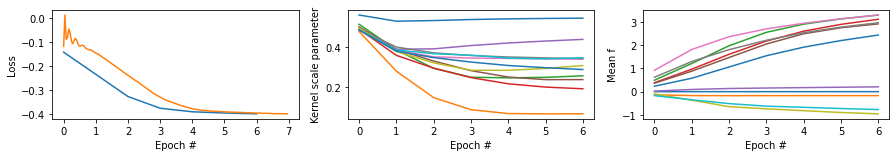

In [25]:
# prot loss function and kernel length
labels = ["Loss", "Kernel scale parameter", "Mean f"]
fig, ax = plt.subplots(1,3,figsize=(15,2))
plot = utils.PlotTraining(fig,ax,labels)#y_lims)
plot.plot([losses,rbf,[np.mean(x,axis=1) for x in means]])
ax[0].plot(np.arange(len(loss_gpu))/25,loss_gpu)

In [26]:
%time WAIC = likelihood.WAIC(model(train_x), train_y, waic_resamples=3)
WAIC

CPU times: user 307 ms, sys: 0 ns, total: 307 ms
Wall time: 306 ms


tensor(-0.4251, device='cuda:0')

In [19]:
# import gc
# i = 0
# for obj in gc.get_objects():
#     if torch.is_tensor(obj) and (obj.device==torch.device('cuda:0')) and obj.size()!=torch.Size([]):
#         print(i, type(obj), obj.size())
#         i+=1

In [ ]:
# define test set (optionally on GPU)
denser = 2 # make test set 2 times denser then the training set
testX = np.linspace(0,1,denser*NSamp)
test_x = torch.tensor(testX).float().cuda(device=0)

In [ ]:
# visualize the result
fig, ax = plt.subplots(2,2,figsize=(13, 8))

model.eval()
with torch.no_grad():
    output = model(test_x)
    
gplink = likelihood.gplink_function

thetas, mixes = gplink(output.mean)
lower, upper = output.confidence_region() #thetas & mix together
thetas_low, mixes_low = gplink(lower)
thetas_upp, mixes_upp = gplink(upper)
 
for t,l,u,c in zip(thetas,thetas_low,thetas_upp,[lik.name for lik in likelihoods]):
    F_mean = t.detach().cpu().numpy()
    if c=='Independence':
        ax[0,0].plot([],[])
    else:
        line, = ax[0,0].plot(testX, F_mean, label = 'GP prediction')
        ax[0,0].fill_between(testX, l.detach().cpu().numpy(),
                    u.detach().cpu().numpy(), color=line.get_color(), alpha=0.5)

ax[0,0].plot(testX,theta1(testX), label = 'True latent function')
ax[0,0].plot(testX,theta2(testX), label = 'True latent function')
ax[0,0].scatter(X,np.zeros_like(X)-0.1,color=colors)
ax[0,0].set_xlabel('x')
ax[0,0].set_ylabel('gp_link(f)')
ax[0,0].set_title('Latent function')
ax[0,0].legend()

for t,l,u in zip(mixes[:-1],mixes_low[:-1],mixes_upp[:-1]):
    F_mean = t.detach().cpu().numpy()
    line, = ax[0,1].plot(testX, F_mean, label = 'GP prediction')
    ax[0,1].fill_between(testX, l.detach().cpu().numpy(),
                    u.detach().cpu().numpy(), color=line.get_color(), alpha=0.5)

ax[0,1].plot(testX,con(testX), label = 'True latent function')
ax[0,1].scatter(X,np.zeros_like(X),color=colors)
ax[0,1].set_xlabel('x')
ax[0,1].set_ylabel('gp_link(f)')
ax[0,1].set_title('Latent function')
ax[0,1].legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) (doubly stochastic)
with gpytorch.settings.num_likelihood_samples(1):
    test_y = likelihood(model(train_x)).rsample()
    Y_sim = test_y.cpu().detach().numpy().squeeze()
skip = 1
ax[1,0].scatter(*Y[::skip].T, label = 'True train data', color=colors[::skip])
ax[1,1].scatter(*Y_sim[::skip].T, label = 'Sample from the model', color=colors[::skip])
for c in [0,1]:
    ax[1,c].set_xlabel('$y_1$')
    ax[1,c].set_ylabel('$y_2$')
ax[1,0].set_title('True data samples')
ax[1,1].set_title('Samples from copula with theta=gplink(f(x))')
# samp.legend()



fig.show()

In [ ]:
n=80
ds =160./n
FI, MI = likelihood.input_information(model,train_y,n,160.)
FI_s, MI_s = likelihood.input_information(model,train_y,n,160., ignore_GP_uncertainty=True)

In [ ]:
plt.plot(np.arange(n+1)*ds,FI_s.cpu().numpy(),label='Mean-GP Fisher information')
plt.plot(np.arange(n+1)*ds,FI.cpu().numpy(),label='Doubly-stoch. Fisher information')
plt.plot(0,0,color='white',label='MI1 = {:.1f} nats'.format(MI_s))
plt.plot(0,0,color='white',label='MI2 = {:.1f} nats'.format(MI))
plt.title("Fisher information")
plt.xlabel('Position, [cm]')
plt.ylabel('FI, nat')
plt.legend()

In [ ]:
FI_gumbel = FI.cpu().numpy()
MI_gumbel = MI.cpu().numpy()
WAIC_gumbel = WAIC.cpu().numpy()

In [ ]:
# plt.plot(np.arange(n+1)*ds,FI_true,label='True Fisher information (Gaussian)',color='black')
# plt.plot(np.arange(n+1)*ds,FI_frank,label='Frank')
# plt.plot(np.arange(n+1)*ds,FI_clay,label='Clayton (all 4)')
plt.plot(np.arange(n+1)*ds,FI_gumbel,label='Gumbel (all 4)')
#plt.plot(np.arange(n+1)*ds,FI_base,label='Baseline (gaussian)', color='grey', alpha=0.5)
# plt.plot(0,0,color='white',label='MI_true = {:.0f} nats\t   WAIC: {:.0f}'.format(MI_true,WAIC_true).expandtabs())
# plt.plot(0,0,color='white',label="MI_frank = {:.0f} nats\t    WAIC: {:.0f}".format(MI_frank,WAIC_frank).expandtabs())
# plt.plot(0,0,color='white',label='MI_clayton = {:.0f} nats\tWAIC: {:.0f}'.format(MI_clay,WAIC_clay).expandtabs())
plt.plot(0,0,color='white',label="MI_gumbel = {:.0f} nats\tWAIC: {:.0f}".format(MI_gumbel,WAIC_gumbel).expandtabs())
#plt.plot(0,0,color='white',label='MI_gauss = {:.0f} nats\t  WAIC: {:.0f}'.format(MI_base,WAIC_base).expandtabs())
plt.title("Fisher information")
plt.xlabel('Position, [cm]')
plt.ylabel('FI, nat')
plt.ylim(0,10)
plt.legend(loc=(1.05,0))